### Analysis with the trained network

This analysis uses the pretrained network. The important files are stored in

In [1]:
!ls -rtlh ~/Dropbox/Server/dl_hcs/

total 5.2G
-rw-r--r-- 1 dueo dueo 4.9M Oct  3 17:03 net_PAPER_aug_epoch512_72x72large_net.pickle
-rw-r--r-- 1 dueo dueo 5.2G Oct  3 17:04 HCS_72x72.npz
-rw-r--r-- 1 dueo dueo 414K Oct  3 17:12 permutations.np.npy
-rw-r--r-- 1 dueo dueo 278K Oct  4 11:02 Test.Rdata
-rw-r--r-- 1 dueo dueo 278K Oct  4 11:21 Test_with_row_index.Rdata


In [73]:
pretrained_net = 'net_PAPER_aug_epoch512_72x72large_net.pickle'
pretrained_net = 'net_PAPER_aug_epoch100_72x72large_net.pickle'
pretrained_net = 'net_PAPER_aug_epoch100_3Classes_72x72large_net.pickle'
#pretrained_net = '/home/dueo/dl-playground/python/HCS/net_PAPER_Reviewer_aug_epoch200_4Classes_72x72large_net_it255.pickle'

pretrained_net = '/home/dueo/dl-playground/python/HCS/net_PAPER_Reviewer_NO_DMSO_aug_epoch200_4Classes_72x72large_net_it500.pickle'

blob4 = 'HCS_72x72.npz' #The Scaled and cut images in the right format

In [74]:
import skimage
skimage.__version__
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import cPickle as pickle
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb


with open(pretrained_net, 'rb') as f:
    net_pretrain = pickle.load(f)

## The training history

In [79]:
net_pretrain.get_all_params_values

<bound method NeuralNet.get_all_params_values of NeuralNet(X_tensor_type=<function tensor4 at 0x58cded8>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0xf4e6150>,
     batch_iterator_train=<__main__.SimpleBatchIterator object at 0xf3d6c50>,
     conv11_filter_size=(3, 3), conv11_num_filters=32,
     conv11_stride=(1, 1), conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv1_stride=(1, 1), conv22_filter_size=(3, 3), conv22_num_filters=64,
     conv22_stride=(1, 1), conv2_filter_size=(3, 3), conv2_num_filters=64,
     conv2_stride=(1, 1), conv33_filter_size=(3, 3),
     conv33_num_filters=128, conv33_stride=(1, 1),
     conv3_filter_size=(3, 3), conv3_num_filters=128, conv3_stride=(1, 1),
     custom_score=None, dropout1_p=0.3, dropout2_p=0.3, dropout3_p=0.3,
     eval_size=0.2, hidden1_num_units=200, hidden2_num_units=200,
     hidden3_num_units=50, input_shape=(None, 5, 72, 72),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', 

In [57]:
net_pretrain.output_num_units

3

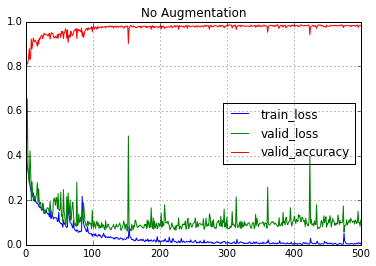

In [75]:
import pandas as pd
dfAug = pd.DataFrame(net_pretrain.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1))
dfAug.to_csv("complex_network_aug.txt")

In [116]:
np.sum(dfAug['dur']) / (60*60) #Total Training Time

5.5353219576676684

The average validation accurracy over the last 100 runs was:

## Evaluation on the test set
### Loading and preprocessing the data

In [60]:
start = time.time()
npzfile = np.load(blob4)
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
#Y = Y - 1#no dmso
Y = Y    #With DMSO
print ("Loaded data in " + str(time.time() - start))

Loaded data in 10.4521279335


In [61]:
Xmean = X.mean(axis = 0)
XStd = np.sqrt(X.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

In [62]:
np.min(X), np.max(X), np.mean(X) #(-2.5272908, 58.301613, -3.3162789e-07)

(-2.5272908, 58.301613, -3.3162789e-07)

In [63]:
Y = np.asarray(Y,dtype='int32')

In [18]:
np.random.seed(seed=42)
perm1 = np.random.permutation(len(Y))
print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
#np.save('permutations.np', perm1)
N_split = int(len(Y) * 0.8)
N_split
idx_train  = perm1[:N_split]
idx_test  = perm1[N_split:]


X_train = X[idx_train,:,:,:]
Y_train = Y[idx_train]
X_test = X[idx_test,:,:,:]
Y_test = Y[idx_test]
cell_rows_test = cell_rows[idx_test]

Sum of permutation 1401824775


In [10]:
idx_test = np.asarray(np.recfromtxt ('test_set_data.csv'))
idx_test
X_train = X[idx_test== False]
X_test = X[idx_test]
Y_train = Y[idx_test== False]
Y_test = Y[idx_test]
X_test.shape, Y_test.shape, X_train.shape, Y_train.shape
cell_rows_test = cell_rows[idx_test]

#### As Suggested by the reviewer

In [64]:
idx_test = np.asarray(np.recfromtxt ('test_set_data_without_one_compound.csv'))
idx_test
X_train = X[idx_test== False]
X_test = X[idx_test]
Y_train = Y[idx_test== False]
Y_test = Y[idx_test]
X_test.shape, Y_test.shape, X_train.shape, Y_train.shape
cell_rows_test = cell_rows[idx_test]

### No DMSO as suggested by reviewer

In [80]:
idx_DMSO = np.asarray(np.recfromtxt ('DMSO_data.csv'))
print('Number of DMSO {}'.format(np.sum(idx_DMSO)))
idx_test = np.asarray(np.recfromtxt ('test_set_data_without_one_compound.csv'))
idx_test
X_train = X[(idx_test == False) & (idx_DMSO == False)]
X_test = X[idx_test & (idx_DMSO == False)]
Y_train = Y[(idx_test == False) & (idx_DMSO == False)]
Y_test = Y[idx_test & (idx_DMSO == False)]
cell_rows_test = cell_rows[idx_test & (idx_DMSO == False)]
X_test.shape, Y_test.shape, X_train.shape, Y_train.shape, cell_rows_test.shape, Y_test.min() #1964 and 10203

Number of DMSO 40783


((2223, 5, 72, 72), (2223,), (9944, 5, 72, 72), (9944,), (2223,), 1)

In [81]:
cell_rows.shape

(52950,)

In [82]:
cell_rows_test.shape, X_test.shape, Y_test.shape

((2223,), (2223, 5, 72, 72), (2223,))

In [102]:
with open('HCS_Test_no_dmso_reviewer_78x78.npz', 'wb') as f:
    np.savez(f, cell_rows_test,X_test,Y_test)

### Prediction on the test set

In [103]:
start = time.time()
pred = net_pretrain.predict(X_test)
ps = net_pretrain.predict_proba(X_test)
print ("The prediction of on {} cells took {}".format(len(X_test), str(time.time() - start)))

The prediction of on 2223 cells took 7.0039088726


In [107]:
if Y_test.max() > 2: #NO_DMSO
    Y_test = Y_test - 1
np.max(pred),np.min(Y_test), np.max(Y_test)

(2, 0, 2)

In [112]:
df = pd.DataFrame(mm)
names = ('PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
df.columns = names
#names = ('PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
names = ('PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
print("Total Accuracy {}".format(1.0*np.sum(m[np.diag_indices(len(names))]) / np.sum(m)))
df

Total Accuracy 0.973009446694


,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
PACLITAXEL Pred,416,26,2
METOCLOPRAMIDE Pred,30,1682,1
DIGOXIN Pred,1,0,65


In [113]:
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:])[0])
print('Normalized confusion matrix')
df = pd.DataFrame(cm_normalized)
df.columns = names
df.index = names
df

Normalized confusion matrix


,PACLITAXEL Pred,METOCLOPRAMIDE Pred,DIGOXIN Pred
PACLITAXEL Pred,0.930649,0.015222,0.029412
METOCLOPRAMIDE Pred,0.067114,0.984778,0.014706
DIGOXIN Pred,0.002237,0.000000,0.955882


## Analysis of the wrongly predicted cells

In [114]:
pred_prob = net_pretrain.predict_proba(X_test)
pred_prob.shape

(2223, 3)

# Global overview

How sure is the net

In [117]:
hist(np.max(pred_prob, axis=1))

### PCA

In [118]:
from sklearn import datasets
from sklearn.decomposition import PCA

explained variance ratio (first two components): [ 0.88328195  0.11671802]


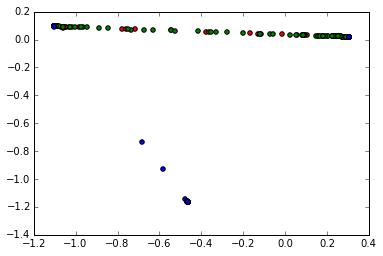

In [119]:
pca = PCA(n_components=2)
X_r = pca.fit(pred_prob).transform(pred_prob)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure()
target_names = names
for c, i, target_name in zip("rgby", [0, 1, 2, 3], target_names):
    plt.scatter(X_r[Y_test == i, 0], X_r[Y_test == i, 1], c=c, label=target_name)

In [120]:
from sklearn.manifold import TSNE

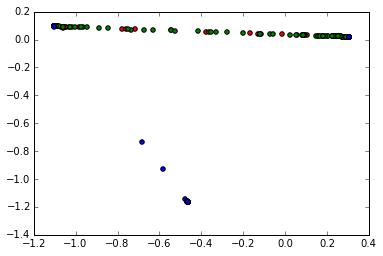

In [121]:
plt.figure()
target_names = names
for c, i, target_name in zip("rgby", [0, 1, 2, 3], target_names):
    plt.scatter(X_r[Y_test == i, 0], X_r[Y_test == i, 1], c=c, label=target_name)

In [125]:
loss = np.zeros(len(Y_test))
for i in range(len(Y_test)):
    loss[i] = pred_prob[i,Y_test[i]]
loss.shape

(2223,)

(array([   44.,     5.,     3.,     5.,     3.,     4.,     6.,     6.,
           12.,  2135.]),
 array([  3.36674658e-14,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

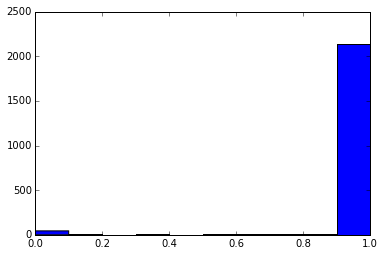

In [126]:
plt.hist(loss)

In [127]:
loss < 0.01
sum(loss < 0.01)

33

In [129]:
wrong = [loss < 0.01]

In [130]:
Y_test.shape, cell_rows_test.shape

((2223,), (2223,))

In [131]:
with open('Test_3Classes_NO_DMSO_Reviewer.pickle', 'wb') as f:
    pickle.dump((pred_prob, Y_test, loss, cell_rows_test), f, -1)
%ls -lh

total 8.9G
-rw-r--r-- 1 dueo dueo  125K Oct  7 00:31 cell_rows.Rdata
-rw-r--r-- 1 dueo dueo   48K Dec  5 19:24 complex_network_aug.txt
-rw-r--r-- 1 dueo dueo  490K Dec  5 11:34 ComplexNetwork.ipynb
-rw-r--r-- 1 dueo dueo  9.2K Oct  4 21:32 complex_network_no_aug.txt
-rw-r--r-- 1 dueo dueo  1.7M Oct  3 11:15 DataHandling.ipynb
-rw-r--r-- 1 dueo dueo  271K Oct  6 20:46 DMSO_data.csv
-rw-r--r-- 1 dueo dueo    19 Aug 13 17:43 experiment.py
-rw-r--r-- 1 dueo dueo 1010K Jul 30 13:10 FirstNetwork_dummy.ipynb
-rw-r--r-- 1 dueo dueo  928K Aug  7 14:06 FirstNetwork.ipynb
-rw-r--r-- 1 dueo dueo  2.3G Jul 28 20:17 HCS_48x48.npz
-rw-r--r-- 1 dueo dueo  5.2G Jul 29 21:17 HCS_72x72.npz
-rw-r--r-- 1 dueo dueo  3.2M Jul 30 12:23 HCS_72x72_small_32.npz
-rw-r--r-- 1 dueo dueo  1.1G Oct  4 10:12 HCS_Test_78x78.npz
-rw-r--r-- 1 dueo dueo  195M Oct  7 00:30 HCS_Test_no_dmso_78x78.npz
-rw-r--r-- 1 dueo dueo  220M Dec  6 14:07 HCS_Test_no_dmso_reviewer_78x78.npz
-rw-r--r-- 1 dueo dueo   30K Oct  6 13:18 Lasag

In [61]:
%load_ext rpy2.ipython
%Rpush pred_prob
%Rpush Y_test
%Rpush loss
%Rpush cell_rows_test
%Rpush cell_rows

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
%%R
save(cell_rows, file='cell_rows.Rdata')

In [62]:
%%R
save(pred_prob, Y_test, loss, cell_rows_test, file='Test_Singel_Well_3Classes_no_dmso.Rdata')

In [63]:
cell_rows_test

array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
         2.54900000e+04,   2.54920000e+04,   2.54930000e+04])